In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from tqdm import tqdm
from src.dag import grn

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

%matplotlib inline

# Some simulations

In [2]:
n_sims = 50
n_genes = 1000

grns = pd.DataFrame([{
    'n': n,
    'r': r,
    'gamma': gamma,
    'cish2': G.compute_h2().cish2
    }
    
    for _ in tqdm(range(n_sims))
        for n, r, gamma in [(n_genes, np.random.uniform(4, 8), np.random.uniform(0.1, 0.5))]
            for G in [grn().add_er_structure(
                                n, 
                                r = r
                          ).add_expression_parameters(
                                sign = np.random.choice([-1, 1], p=[0.5, 0.5], size=(n, n)),
                                weight = gamma)
                     ]
])

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


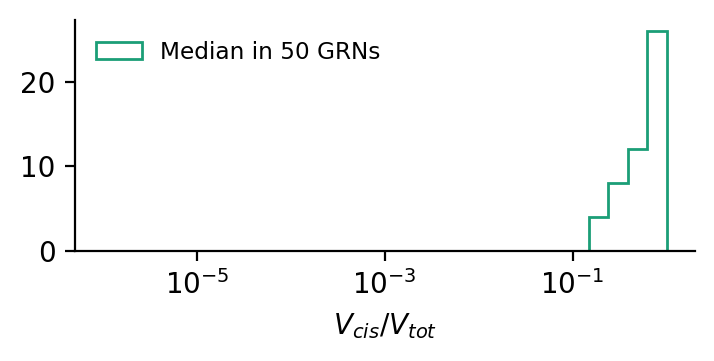

In [3]:
plt.figure(figsize=(4,1.5), dpi=200);

plt.hist(grns.cish2.apply(np.median), 
         bins=np.geomspace(1e-6, 1e0, 30), 
         histtype='step', 
         label='Median in {} GRNs'.format(grns.shape[0])
);
plt.xlabel(r'$V_{cis}/V_{tot}$');
plt.legend(fontsize='small', frameon=False);
plt.semilogx();
sns.despine();

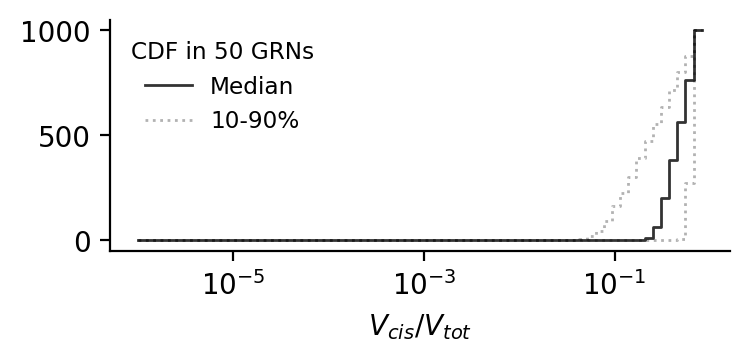

In [4]:
plt.figure(figsize=(4,1.5), dpi=200);

x_bins = np.geomspace(1e-6, 1e0, 71)
y_vals = np.quantile(grns.cish2.apply(lambda x: np.cumsum(np.histogram(x, bins = x_bins)[0])).tolist(), q=[0.1, 0.5, 0.9], axis=0)

for y, par in zip(y_vals, [{'c':'k', 'alpha':0.3, 'linestyle':'dotted', 'linewidth':1.0, 'label':''},
                           {'c':'k', 'alpha':0.8, 'linestyle':'solid', 'linewidth':1.0, 'label':'Median'},
                           {'c':'k', 'alpha':0.3, 'linestyle':'dotted', 'linewidth':1.0, 'label':'10-90%'}]):
    plt.step(x_bins[:-1], y, **par);
    
plt.semilogx();
plt.xlabel(r'$V_{cis}/V_{tot}$');
plt.legend(title='CDF in {} GRNs'.format(grns.shape[0]), 
           title_fontsize='small', 
           fontsize='small', 
           frameon=False);
plt.semilogx();
sns.despine();

# Data from Ouwens 2020

_Citation_: Ouwens, K.G., Jansen, R., Nivard, M.G. et al. "A characterization of cis- and trans-heritability of RNA-Seq-based gene expression". Eur J Hum Genet 28, 253–263 (2020). https://doi.org/10.1038/s41431-019-0511-5.

_Table S2_: All (unfiltered) results from heritability estimates

In [5]:
s2 = pd.read_excel('../data/41431_2019_511_MOESM2_ESM.xlsx', sheet_name=None)

[(k, v.shape) for k,v in s2.items()]

[('Sheet1', (51, 3)), ('allresults_2019-05-12', (52844, 48))]

## Gene filtration (as in Ouwens 2020)

A total of 52,844 genes were analyzed, and subsequently filtered for being protein coding, having read counts above zero in at least 85% samples in each zygosity group (e.g. expressed in in at least 780 MZ twins and 255 DZ twins), a median expression count above 10, and more than 20 SNPs in the cis-window, resulting in an analysis of 11,353 genes (Supplementary Table 2).

In [6]:
h2 = s2['allresults_2019-05-12'].query('''gene_biotype=="protein_coding" & \
                                          zerocounts_in_MZ <= (918-780) & \
                                          zerocounts_in_DZ <= (300-255) & \
                                          raw_median_count_per_gene > 10 & \
                                          N_SNPS > 20
                                       '''
                                ).copy()

display(h2.shape, h2.columns, h2.head())

(11409, 48)

Index(['GENE', 'raw_mean_count_per_gene', 'raw_median_count_per_gene',
       'residualized_mean_count_per_gene',
       'residualized_median_count_per_gene', 'zerocounts_in_DZ',
       'zerocounts_in_MZ', 'zerocounts_in_all', 'falconer_h2', 'MZcorrelation',
       'DZcorrelation', 'ACE_A', 'ACE_C', 'ACE_E', 'ACE_AICc', 'AE_A', 'AE_E',
       'AE_AICc', 'ACE_CE_Pvalue', 'GCTA_VG1ofVp', 'GCTA_VG1ofVP_SE',
       'GCTA_VG2ofVp', 'GCTA_VG2ofVp_SE', 'GCTA_Sum', 'GCTA_Sum_SE', 'N_SNPS',
       'hgnc_symbol', 'chromosome_name', 'start_position', 'end_position',
       'ensembl_transcript_id', 'gene_biotype', 'cis_eqtl_chromosome',
       'cis_eqtl_SNP', 'cis_eqtl_bp', 'cis_eqtl_effect_allele',
       'cis_eqtl_non_affect_allele', 'cis_eqtl_beta', 'cis_eqtl_P',
       'cis_eqtl_FDR', 'trans_eqtl_chromosome', 'trans_eqtl_SNP',
       'trans_eqtl_bp', 'trans_eqtl_effect_allele',
       'trans_eqtl_non_affect_allele', 'trans_eqtl_beta', 'trans_eqtl_P',
       'trans_eqtl_FDR'],
      dtype='obje

,GENE,raw_mean_count_per_gene,raw_median_count_per_gene,residualized_mean_count_per_gene,residualized_median_count_per_gene,zerocounts_in_DZ,zerocounts_in_MZ,zerocounts_in_all,falconer_h2,MZcorrelation,...,cis_eqtl_P,cis_eqtl_FDR,trans_eqtl_chromosome,trans_eqtl_SNP,trans_eqtl_bp,trans_eqtl_effect_allele,trans_eqtl_non_affect_allele,trans_eqtl_beta,trans_eqtl_P,trans_eqtl_FDR
0,ENSG00000000419,133.743537,130.906235,1.180238e-18,-0.008395,0,0,0,-0.197863,0.106157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000000457,124.870722,123.678165,2.059187e-18,-0.008612,0,0,0,0.165453,0.092706,...,5.330160e-13,1.479483e-11,1.0,1-169751853,169751853.0,T,C,-0.215534,2.440030e-08,4.036602e-07
2,ENSG00000000460,57.516552,56.681662,3.698310e-18,-0.012563,0,0,0,0.357618,0.335635,...,0.000000e+00,0.000000e+00,1.0,1-169580717,169580717.0,C,T,-0.272360,3.471390e-10,7.216771e-09
3,ENSG00000000938,13099.475192,12631.371927,-1.336965e-18,0.015804,0,0,0,0.397230,0.368861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000000971,20.054503,16.879363,3.629941e-18,-0.009700,3,6,12,0.561934,0.485259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# add some stuff to Ouwens' df
h2['GCTA_Frac'] = h2['GCTA_VG2ofVp'] / h2['GCTA_Sum']
h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$']] = h2[['cis_eqtl_beta', 'trans_eqtl_beta']] ** 2

display(h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$', 'GCTA_Frac']].describe())

,$\beta^2_{cis}$,$\beta^2_{trans}$,GCTA_Frac
count,5902.000000,5902.000000,11353.000000
mean,0.265897,0.132362,0.204536
std,0.366534,0.203661,0.232011
min,0.026803,0.024794,0.000001
25%,0.073347,0.046914,0.028383
50%,0.142890,0.072513,0.114606
75%,0.324170,0.133108,0.306585
max,7.492373,5.847836,0.999996


# Figure 1

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


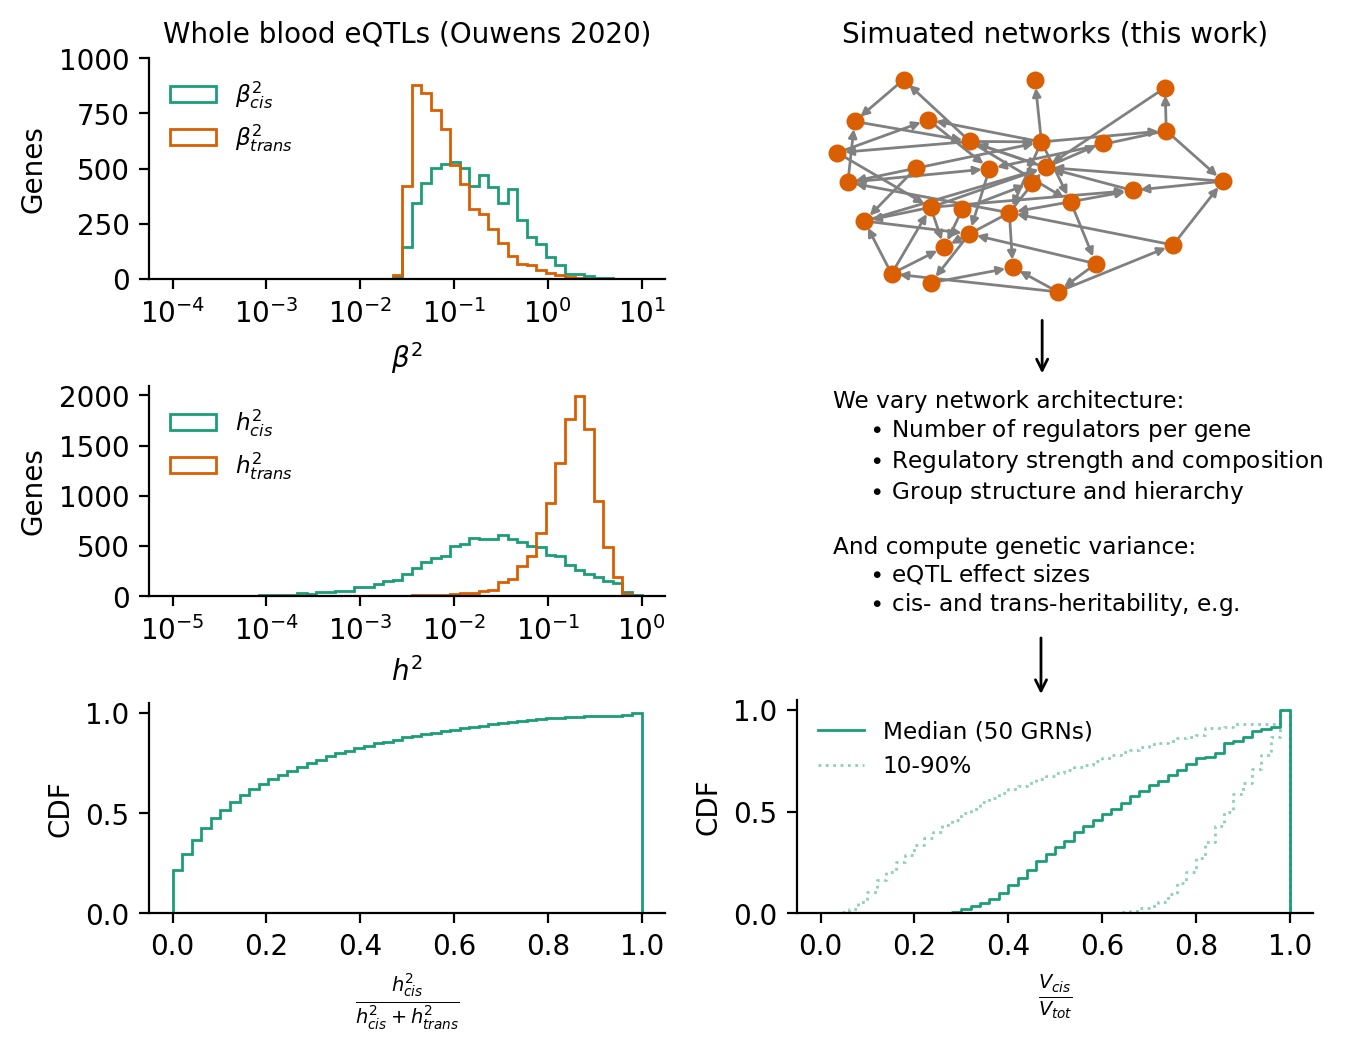

In [17]:
fig = plt.figure(figsize=(6, 4.5), dpi=200);

# separate grids, might not be necessary
gs1 = fig.add_gridspec(nrows=2, ncols=1, left=0.55, right=0.98, bottom=0.0, top=0.95, hspace=0.5, height_ratios=[2.2, 1])
gs2 = fig.add_gridspec(nrows=3, ncols=1, left=0.01, right=0.44, bottom=0.0, top=0.95, hspace=0.5, height_ratios=[1.05, 1, 1])



# distribution of cis- and trans- eQTL effects (Ouwens)
ax = fig.add_subplot(gs2[0,0]);

for c in [r'$\beta^2_{cis}$', r'$\beta^2_{trans}$']:
    h2.hist(c, bins=np.geomspace(1e-4, 1e1, 50), histtype='step', grid=0, label=c, ax=ax);

ax.set_xlabel(r'$\beta^2$');
ax.set_ylabel('Genes'.format(h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$']].dropna().shape[0]));
ax.set_xscale('log');
ax.set_xticks(np.geomspace(1e-4, 1e1, 6));
ax.set_yticks(np.linspace(0, 1000, 5));
ax.legend(title='',
          title_fontsize='small', 
          fontsize='small',
          frameon=False,
          loc='upper left'
         );
ax.set_title('Whole blood eQTLs (Ouwens 2020)', fontsize='medium');


# distribution of cis- and trans- heritability (Ouwens)
ax = fig.add_subplot(gs2[1,0]);

for col,name in zip(['GCTA_VG2ofVp','GCTA_VG1ofVp'], [r'$h^2_{cis}$', r'$h^2_{trans}$']):
    h2.hist(
        col, 
        bins=np.geomspace(1e-5,1e0,50), 
        histtype='step', 
        grid=0,
        label=name,
        ax=ax);
            
ax.legend(title='',
          title_fontsize='small',
          fontsize='small', 
          frameon=False,
          loc='upper left'
         );
ax.set_xlabel(r'$h^2$');
ax.set_xscale('log');
ax.set_xticks(np.geomspace(1e-5, 1e0, 6));
ax.set_title(None);
ax.set_ylabel('Genes');
ax.set_yticks(np.linspace(0, 2000, 5));


# distribution of cis- heritability fraction (Ouwens)
ax = fig.add_subplot(gs2[2,0]);

h2.hist('GCTA_Frac', 
        bins=np.linspace(0, 1, 50),  
        histtype='step', 
        grid=0,
        cumulative=True,
        density=True,
        label=None,#'{0} protein-coding genes'.format(h2.shape[0]),
        ax=ax);

ax.set_xlabel(r'$\frac{h^2_{cis}}{h^2_{cis} + h^2_{trans}}$');
ax.set_ylabel('CDF');#'Density ({0} genes)'.format(h2.shape[0]));
ax.set_title(None);
yl0=ax.get_ylim()


# fun lil network guy
ax = fig.add_subplot(gs1[0,0]);

nx.draw_kamada_kawai(nx.binomial_graph(n=30, p=0.05, seed=0, directed=True),
                     node_size=30, 
                     node_color=plt.get_cmap('Dark2')(1),
                     edge_color='gray',
                     width=1,
                     arrowsize=6,
                     ax=ax)
#ax.text(-1.1, 1.25, 'Synthetic GRNs:');
ax.set_title('Simuated networks (this work)', fontsize='medium');
ax.set_ylim(-3.2, 1.2);
ax.set_xlim(-0.8, 1.2);


ax.annotate("", xy=(0.15, -1.8), xytext=(0.15, -1.2), arrowprops=dict(arrowstyle="->"))

ax.text(-0.66, -1.9, 
'''We vary network architecture:
     {0} Number of regulators per gene
     {0} Regulatory strength and composition 
     {0} Group structure and hierarchy

And compute genetic variance:
     {0} eQTL effect sizes
     {0} cis- and trans-heritability, e.g.
'''.format(r'$\bullet$'), 
        va = 'top', 
        ha = 'left',
        fontsize='small');


# distribution of cis- heritability fraction (synthetic data)
ax = fig.add_subplot(gs1[1,0]);

x_bins = np.linspace(0, 1, 51)
y_vals = np.quantile(grns.cish2.apply(lambda x: np.cumsum(np.histogram(x, bins = x_bins)[0])).tolist(), q=[0.1, 0.5, 0.9], axis=0)
color0 = plt.get_cmap('Dark2')(0)

for y, par in zip(y_vals, [{'color':color0, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':''},
                           {'color':color0, 'alpha':1.0, 'linestyle':'solid', 'linewidth':1.0, 'label':'Median ({0} GRNs)'.format(n_sims)},
                           {'color':color0, 'alpha':0.5, 'linestyle':'dotted', 'linewidth':1.0, 'label':'10-90%'}]):
    ax.step(x_bins, np.hstack([y, 0])/n_genes, where='post', **par);
    
ax.set_xlabel(r'$\frac{V_{cis}}{V_{tot}}$');
ax.set_ylabel('CDF');# ({0} genes)'.format(n_genes));
ax.set_ylim(yl0);
ax.legend(fontsize='small', frameon=False, loc='upper left');

ax.annotate("", xy=(0.47, 1.05), xytext=(0.47, 1.38), arrowprops=dict(arrowstyle="->"))

# stuff for the figure
# fig.suptitle('Figure 1: Motivation and overview of the study');
sns.despine();

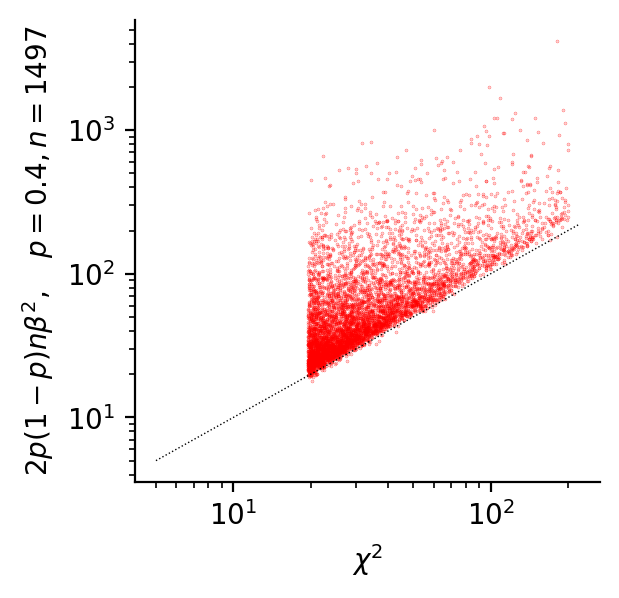

In [64]:
plt.figure(figsize=(3,3), dpi=200)
plt.plot( ss.chi2.isf(h2.trans_eqtl_P, df=1), 
          h2[r'$\beta^2_{trans}$'] * (2 * 0.4 * 0.6 * 1497), 'r.', alpha=0.5, ms=0.5)
plt.plot([5, 220], [5,220], 'k:', linewidth=0.5)
plt.xlabel(r'$\chi^2$');
plt.ylabel(r'$2 p (1-p) n \beta^2, \quad p=0.4, n=1497$');
plt.loglog();
sns.despine();